<a href="https://colab.research.google.com/github/bmeyboom/robot_cnn_trainer/blob/main/robot_cnn_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

General Notes:
- check that data with no driving labels is not included in training
- figure out how many of each type of command we have (turn right, left, straight), and make sure we use equal amounts of each
- need ~2000 images!! Miti said train to just complete outer loop, and then separately inner loop
- Check images and associated commands to make sure the associated commands make sense, potential for lag between command and image recordings
  - to do this assess ~20 of each command/image, RANDOMLY (important)


  Notes Monday, March 29th:
  - I think we have our left and right turns mixed up
  - disproportional amounts of left vs right vs straight turns
  - images associated with turns maybe kinda wrong? don't know...
  - need more data!
  
  Wednesday notes:
  - had to modify a bunch of things to avoid exceeding RAM limits
  - getting 20% training accuracy... need to fix. maybe has to do with the activation functions?

In [ ]:
#download from gdrive or take from folder?
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7Ey3KAK1dw-9sxvCNPmk__z7BTAgG_uNwJoc0rk9R_BX9Oo7TsY-w


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_dir = "/content/drive/MyDrive/test_data_enph353/img"
csv_file = "/content/drive/MyDrive/test_data_enph353/data.csv"
pickle_f = "/content/drive/MyDrive/test_data_enph353/pickled_data.pickle"
checkpoint_filepath = "/content/drive/MyDrive/test_data_enph353/"

In [ ]:
def one_hot_encoding(data, n = 3):
# 0 for no turn
# 1 for right turn (+ angular)
# 2 for left turn (- angular)
  data_float = float(data)
  y = [0 if (data_float == 0.0) else 1 if (data_float > 0) else 2] # > 0 is turning right, = 0 is straight, < 0 is turning left
  encoding = np.zeros(n)
  encoding[y] = 1
  return encoding

In [ ]:
# TRYING NEW DATA PARSING
#start with angular first
import csv
import math
import numpy as np
import re
import cv2

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image

from google.colab.patches import cv2_imshow # for image display

# getting rid images without driving labels?
# display images and associated labels
# in batches (random <-)

data_list = []
with open(csv_file, 'r', newline = '') as f:
  reader = csv.reader(f, delimiter = ',')
  # r[0] = linear, r[1] = angular, r[2] = image
  for row in reader:
    if 'png' not in row[0] and not row[0] == row[1]:
      if not row[0] == "" and not row [1] == "": # MAKE SURE NO EMPTY COMMANDS!
        data_list.append(row)

tr = [] # turn right
tl = [] # turn left
nt = [] # go straight (no turn)
for d in data_list:
  fl = float(d[1])
  if fl > 0:
    tr.append(d)
  elif fl < 0:
    tl.append(d)
  else:
    nt.append(d)

print(len(tr))
print(len(tl))
print(len(nt))
# not an equal amount of each command!!


494
107
1872


In [ ]:
print(data_list[0])

['0.23914845000000007', '0.0', '/home/fizzer/ros_ws/src/robot_control/controller_pkg/launch/images/12.png']


In [ ]:
# # to visually check the data

# # RIGHT TURNS
# np.random.shuffle(tr)
# np.random.shuffle(tl)
# np.random.shuffle(nt)

# for i in range(20):
#   # get file path
#   path = tr[i][2]
#   start_index = path.index('img/') + 3
#   number = path[start_index:]

#   path = img_dir + '/' + number
#   # cv2 option
#   im = cv2.imread(path)
#   im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

#   # Displaying the image
#   cv2_imshow(im)




In [ ]:
def load_pickle(obj):
  with open(pickle_f,"rb") as fileOpener:
    while True:
        try:
            obj.append(pickle.load(fileOpener))
        except EOFError:
            print('file ended')
            break

In [ ]:
import pickle
# creating new pickle file with grayscale images as matrices
# for i in range(len(data_list)):

outfile = open(pickle_f, 'wb')

for i in range(len(data_list)):
 # get file path
  path = data_list[i][2]
  # parse path to get image number
  if 'img/' in path:
    start_index = path.index('img/') + 3
  else:
    continue
  number = path[start_index:]
  path = img_dir + '/' + number
  # # # load image
  try:
    im = cv2.imread(path)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    sml = cv2.resize(gray, (int(gray.shape[1]/6), int(gray.shape[0]/6)))
    data = [data_list[i][0], one_hot_encoding(data_list[i][1]), np.array(sml)]
    pickle.dump(data, outfile)
  except cv2.error as e:
    print('file not found')

outfile.close()

file not found
file not found
file not found
file not found
file not found
file not found
file not found
file not found
file not found
file not found
file not found


In [ ]:
# load pickle file data
pickled_data_list = []
load_pickle(pickled_data_list)
print(len(pickled_data_list))


file ended
2345


In [ ]:
print(load_pickle([]))

None


In [ ]:
# # LEFT TURNS

# for i in range(20):
#   # get file path
#   path = tl[i][2]
#   start_index = path.index('img/') + 3
#   number = path[start_index:]

#   path = img_dir + '/' + number
#   # cv2 option
#   im = cv2.imread(path)
#   im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#   cv2_imshow(im)
#   sml = cv2.resize(im, ())
#   # Displaying the image
#   cv2_imshow(im)




ValueError: ignored

In [ ]:
# # NO TURNS

# for i in range(20):
#   # get file path
#   path = nt[i][2]
#   start_index = path.index('img/') + 3
#   number = path[start_index:]

#   path = img_dir + '/' + number
#   # cv2 option
#   im = cv2.imread(path)
#   im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#   # Displaying the image
#   cv2_imshow(im)




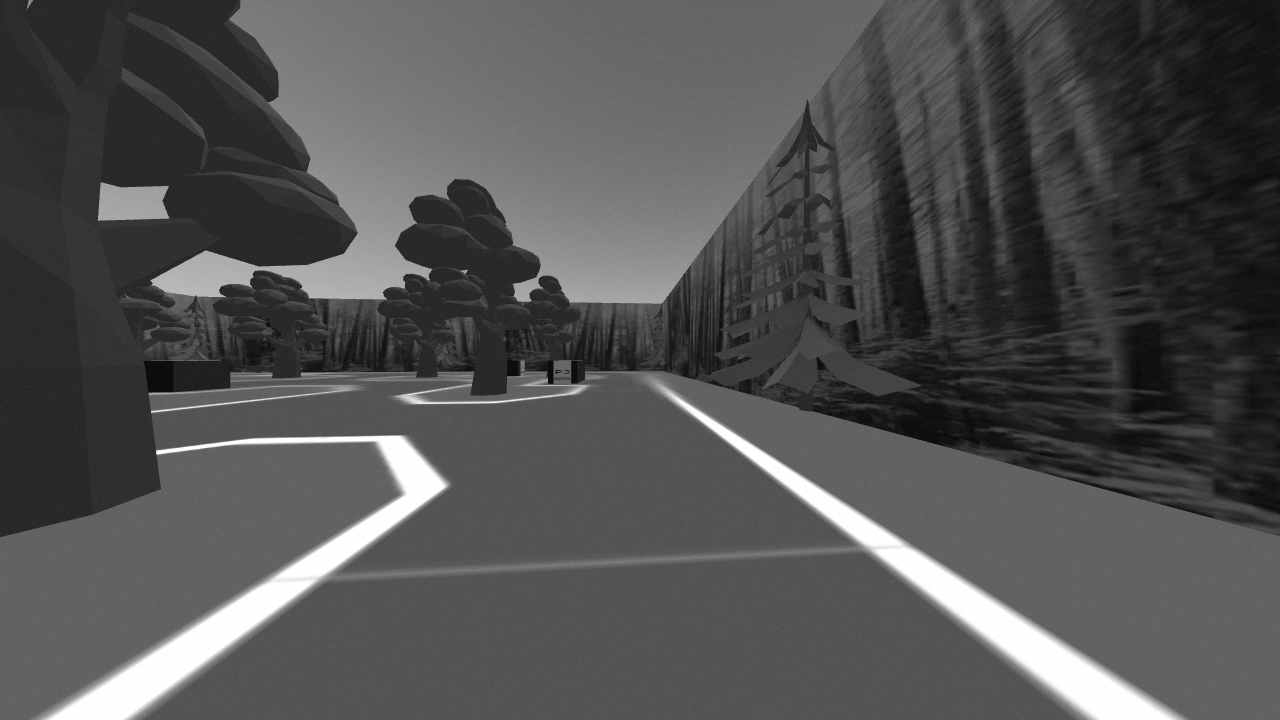

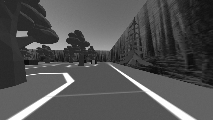

[[ 41  43  45 ...  21  22  24]
 [ 42  44  44 ...  24  20  19]
 [ 43  43  43 ...  18  18  23]
 ...
 [ 97  97  97 ...  97  99 100]
 [ 98  99  98 ...  99  96  98]
 [100  97  97 ...  98  97  99]]


In [ ]:
#format data in here

# from collections import Counter
# from matplotlib import pyplot as plt
# from PIL import Image

# # getting rid images without driving labels?
# # display images and associated labels
# # in batches (random <-)

np.random.shuffle(data_list)

# X is the images, y is the associated cmd_vel values
X_og = []
y_og = []

shortest = min(len(tr), len(tl), len(nt))

def parse_data(data_list, X_og, y_og):
  # for i in range(len(data_list)):
    for i in range(1)
    # if i == int(len(data_list)/2):
    #   print('halfway there')

    # get file path
    path = data_list[i][2]

    # parse path to get image number
    if 'img/' in path:
      start_index = path.index('img/') + 3
    else:
      continue
    number = path[start_index:]

    # print("Number: ")
    # print(number)
    path = img_dir + '/' + number
    # # # load image
    # im = Image.open(path)
    try:
      # cv2 option
      im = cv2.imread(path)
      gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

      cv2_imshow
      cv2_imshow(sml)
      # add image to X data as matrix
      X_og.append(np.array(gray))
      # print(data_list[i][1])
      # # get associated turning data
      y_og.append(one_hot_encoding(data_list[i][1]))
    except cv2.error as e:
      print('file not found')
      # print(path)

l = len(data_list)
parse_data(data_list[0:int(l/4)], X_og, y_og)


In [ ]:
parse_data(data_list[int(l/4):int(l/2)], X_og, y_og)

file not found
file not found
file not found
halfway there
file not found


In [ ]:
parse_data(data_list[int(l/2):int(3*l/4)], X_og, y_og)


file not found
halfway there
file not found


In [ ]:
parse_data(data_list[int(3*l/4):], X_og, y_og)

file not found
halfway there
file not found
file not found


In [ ]:
print(len(X_og))
print(len(data_list))
print(len(y_og))

2345
2473
2345


In [ ]:
# From lab 5 sample code
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [ ]:
#begin keras and tensorflow stuff
%tensorflow_version 1.14.0
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
model = Sequential()

def make_model(sequential, X):
  # For grayscale images we need to use 1D Conv and MaxPooling layers!

  # one layer
  # one dimensional convolution for grayscale image
  model.add(Conv1D(256, 3, input_shape=X.shape[1:]))
  model.add(Activation('linear'))
  model.add(MaxPooling1D(pool_size=(2)))

  # # second layer
  model.add(Conv1D(256, (3), input_shape=X.shape[1:]))
  model.add(Activation('softmax'))
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(layers.Dropout(0.5))

  # flattens so that Dense can be used
  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  # Trying linear activation (regressive) vs classification (softmax)
  model.add(Dense(3, activation='softmax'))

  # we should decide what type of activation function we want :)
  # options: sigmoid, tanh, ReLU
  #model.add(Activation('sigmoid'))

NameError: ignored

In [ ]:
def train(model, X, y):
  history_conv = model.fit(X, y, batch_size=8, epochs=80, validation_split=0.1)

  plt.plot(history_conv.history['loss'])
  plt.plot(history_conv.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'val loss'], loc='upper left')
  plt.show()

  plt.plot(history_conv.history['acc'])
  plt.plot(history_conv.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy (%)')
  plt.xlabel('epoch')
  plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
  plt.show()

In [ ]:
# cut up the training so that RAM doesn't get exceeded
for i in range(5):
  l_x = len(X_og)
  X = np.asarray(X_og[int(i*l_x/4):int((i+1)*l_x/4)])
  y = np.asarray(y_og[int(i*l_x/4):int((i+1)*l_x/4)])

  print(X.shape[1:])
  print(X.shape)
  print(y)

  # normalize image data
  X= X/255.0
  if i == 0:
    make_model(model, X)
    model.summary()
    reset_weights(model)
    # compile
    LEARNING_RATE = 1e-4
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=LEARNING_RATE),
                metrics=['accuracy'])
  train(model, X, y)

(720, 1280)
(586, 720, 1280)
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 719, 256)          655616    
_________________________________________________________________
activation_2 (Activation)    (None, 719, 256)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 359, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 357, 256)          196864    
_________________________________________________________________
activation_3 (Activation)    (None, 357, 256)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 178, 256)          0         
_____________

In [ ]:
#save the model here
#we'll have to download from drive to our local
model.save('/content/drive/MyDrive/test_data_enph353/model')
model_path = 'model.h5'
model.save(model_path)

In [ ]:
# to reuse previously trained model and train further
# # load weights
# model.load_weights("weights.best.hdf5")
# # Compile model (required to make predictions)
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print("Created model and loaded weights from file")

In [ ]:
# trying something new
turning_y = []
turning_x = []

for i in range(len(y_og)):
  if y_og[i][0] == 0:
    turning_y.append(y_og[i])
    turning_x.append(X_og[i])


t_x = np.asarray(turning_x)
t_y = np.asarray(turning_y)

# print(y)

# normalize image data
X= X/255.0
print(len(y_og))
print(len(turning_y))

new_model = tf.keras.models.load_model(model_path)
history_conv = model.fit(t_x, t_y, batch_size = 3, epochs = 5, validation_split=0.1)


In [ ]:
print(t_y)

In [ ]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()
